In [ ]:
import re
import string
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Embedding, LSTM, Conv1D, GlobalMaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
# from imblearn.over_sampling import SMOTE


# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.models import Sequential

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline
from tqdm import tqdm


import nltk  # Import pustaka NLTK (Natural Language Toolkit).
# nltk.download('punkt_tab')  # Mengunduh dataset yang diperlukan untuk tokenisasi teks.
# nltk.download('stopwords')  # Mengunduh dataset yang berisi daftar kata-kata berhenti (stopwords) dalam berbagai bahasa.

In [22]:
df = pd.read_csv('prabowo_menjawab.csv')
df.head()

,Nama Akun,Komentar,Sumber
0,@azzahrasyamilarahmat5028,11/100 Is Real...,Narasi Newsroom
1,@faritrohman3969,Saya kecewa cuma gara gara beberapa anak kelua...,Narasi Newsroom
2,@moradepadli5676,Prabowo aneh,Narasi Newsroom
3,@anggaviali1188,Nonton tanpa baca komen itu lebih baik,Narasi Newsroom
4,@derikoswaranda3500,woyyy mana ini?? ko komenan ga ada yg pro pa w...,Narasi Newsroom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15020 entries, 0 to 15019
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Nama Akun  15017 non-null  object
 1   Komentar   15016 non-null  object
 2   Sumber     15020 non-null  object
dtypes: object(3)
memory usage: 352.2+ KB


In [23]:
print(f'jumlah data sebelum dropna : {len(df)}')
df = df.dropna()
print(f'jumlah data setelah dropna : {len(df)}')

jumlah data sebelum dropna : 15020
jumlah data setelah dropna : 15013


In [24]:
print(f'Jumlah data duplikat      : {df['Komentar'].duplicated().sum()}')

df = df.drop_duplicates(subset=['Komentar'])
print(f'Setelah handling duplikat : {df['Komentar'].duplicated().sum()}')

Jumlah data duplikat      : 380
Setelah handling duplikat : 0


In [25]:
df = df.reset_index(drop=True) #reset index
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14633 entries, 0 to 14632
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Nama Akun  14633 non-null  object
 1   Komentar   14633 non-null  object
 2   Sumber     14633 non-null  object
dtypes: object(3)
memory usage: 343.1+ KB


# preprocessing teks

In [8]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka
 
    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text

In [9]:
def casefoldingText(text): # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text

In [26]:
def tokenizingText(text):
    if isinstance(text, str):
        # Tokenisasi teks
        tokens = word_tokenize(text)
        
        # Handling untuk kata yang terlalu panjang
        max_token_length = 500  # Batas panjang token untuk model 
        if len(tokens) > max_token_length:
            print(f"Teks terlalu panjang! Jumlah token: {len(tokens)}")
            tokens = tokens[:max_token_length]  # Potong jika terlalu panjang
            print(f"Teks telah dipotong menjadi {len(tokens)} token.")
        
        return tokens  # Kembalikan token hasil tokenisasi
    else:
        return []  # Kembalikan list kosong jika input bukan string

In [11]:
def stemmingText(text): # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
 
    # Memecah teks menjadi daftar kata
    words = text.split()
 
    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]
 
    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)
 
    return stemmed_text

In [97]:
listStopwords = set(stopwords.words('indonesian'))
listStopwords1 = set(stopwords.words('english'))
listStopwords.update(listStopwords1)
listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy","kali","lu","beliau"])

def filteringText(text): # Menghapus stopwords dalam teks
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

In [13]:
def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

In [14]:
# Load kamus slang dari GitHub
slang_df = pd.read_csv('https://raw.githubusercontent.com/nasalsabila/kamus-alay/refs/heads/master/colloquial-indonesian-lexicon.csv')
slang_dict = dict(zip(slang_df['slang'], slang_df['formal']))

# Fungsi untuk memperbaiki kata slang
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        fixed_words.append(slang_dict.get(word.lower(), word))

    return ' '.join(fixed_words)

In [15]:
df.isna().sum()

Nama Akun    0
Komentar     0
Sumber       0
dtype: int64

In [27]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
df['text_clean'] = df['Komentar'].apply(cleaningText)
 
# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
df['text_casefoldingText'] = df['text_clean'].apply(casefoldingText)
 
# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
df['text_slangwords'] = df['text_casefoldingText'].apply(fix_slangwords)
 
# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
df['text_tokenizingText'] = df['text_slangwords'].apply(tokenizingText)
 
# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
df['text_stopword'] = df['text_tokenizingText'].apply(filteringText)
 
# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
df['text_akhir'] = df['text_stopword'].apply(toSentence)



Teks terlalu panjang! Jumlah token: 519
Teks telah dipotong menjadi 500 token.
Teks terlalu panjang! Jumlah token: 820
Teks telah dipotong menjadi 500 token.
Teks terlalu panjang! Jumlah token: 794
Teks telah dipotong menjadi 500 token.
Teks terlalu panjang! Jumlah token: 702
Teks telah dipotong menjadi 500 token.


In [28]:
# Load model dan tokenizer
tokenizer = AutoTokenizer.from_pretrained("Aardiiiiy/indobertweet-base-Indonesian-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("Aardiiiiy/indobertweet-base-Indonesian-sentiment-analysis")

# Buat pipeline klasifikasi
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=False, device=-1)

tqdm.pandas() # Tampilkan progress bar saat apply

# Prediksi sentimen pada kolom 'text_akhir'
df['bert_label'] = df['text_akhir'].progress_apply(lambda x: pipe(x)[0]['label'])

Device set to use cpu
c:\Users\lenovo\ProyekNLP\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
100%|██████████| 14633/14633 [13:17<00:00, 18.34it/s]


In [30]:
print(df['bert_label'].value_counts())

bert_label
Negative    8305
Neutral     4003
Positive    2325
Name: count, dtype: int64


Preprocessing Text

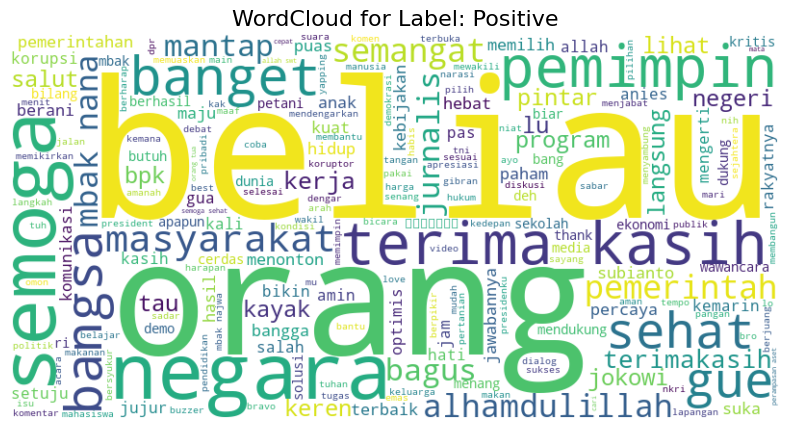

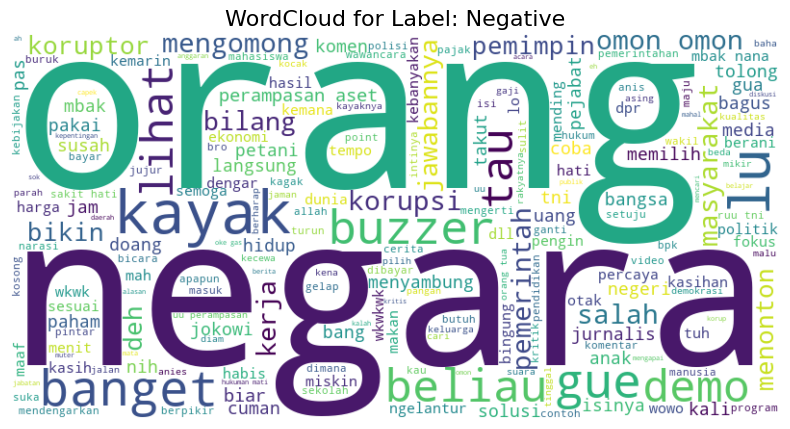

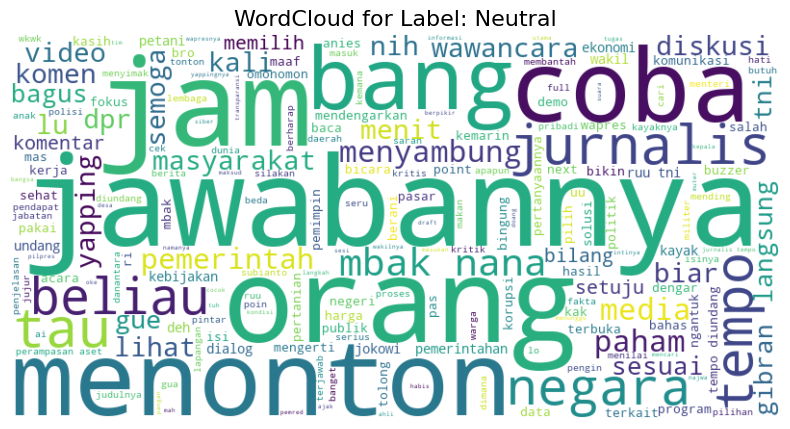

In [ ]:
# Kata yang ingin disaring dari visualisasi WordCloud
custom_stopwords = set(stopwords.words('indonesian'))
custom_stopwords.update(['prabowo', 'presiden', 'rakyat', 'kalo','indonesia',])  # bisa tambah lagi

def generate_wordcloud_for_label(label_name):
    # Filter dataframe sesuai label
    filtered_df = df[df['bert_label'] == label_name]

    # Gabungkan dan filter kata
    all_tokens = [word for tokens in filtered_df['text_stopword'] for word in tokens if word not in custom_stopwords]
    all_words = ' '.join(all_tokens)

    # Generate dan tampilkan wordcloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'WordCloud for Label: {label_name}', fontsize=16)
    plt.axis('off')
    plt.show()

# Contoh pemanggilan
generate_wordcloud_for_label('Positive')
generate_wordcloud_for_label('Negative')
generate_wordcloud_for_label('Neutral')  # jika ada


In [40]:
df.to_csv('hasil_preprocessing.csv', index=False)

In [67]:
df.head()

,Nama Akun,Komentar,Sumber,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir,bert_label
0,@azzahrasyamilarahmat5028,11/100 Is Real...,Narasi Newsroom,Is Real,is real,is real,"[is, real]",[real],real,Negative
1,@faritrohman3969,Saya kecewa cuma gara gara beberapa anak kelua...,Narasi Newsroom,Saya kecewa cuma gara gara beberapa anak kelua...,saya kecewa cuma gara gara beberapa anak kelua...,saya kecewa cuma gara gara beberapa anak kelua...,"[saya, kecewa, cuma, gara, gara, beberapa, ana...","[kecewa, gara, gara, anak, keluarga, koruptor,...",kecewa gara gara anak keluarga koruptor uu pra...,Negative
2,@moradepadli5676,Prabowo aneh,Narasi Newsroom,Prabowo aneh,prabowo aneh,prabowo aneh,"[prabowo, aneh]","[prabowo, aneh]",prabowo aneh,Negative
3,@anggaviali1188,Nonton tanpa baca komen itu lebih baik,Narasi Newsroom,Nonton tanpa baca komen itu lebih baik,nonton tanpa baca komen itu lebih baik,menonton tanpa baca komen itu lebih baik,"[menonton, tanpa, baca, komen, itu, lebih, baik]","[menonton, baca, komen]",menonton baca komen,Neutral
4,@derikoswaranda3500,woyyy mana ini?? ko komenan ga ada yg pro pa w...,Narasi Newsroom,woyyy mana ini ko komenan ga ada yg pro pa wowo,woyyy mana ini ko komenan ga ada yg pro pa wowo,woy mana ini kok komentar enggak ada yang pro ...,"[woy, mana, ini, kok, komentar, enggak, ada, y...","[komentar, pro, wowo]",komentar pro wowo,Neutral


In [90]:
from imblearn.over_sampling import SMOTE

In [102]:
print(f"Jumlah data sebelum SMOTE: {len(df)}")
print("Distribusi awal:\n", df['bert_label'].value_counts().to_string())

Jumlah data sebelum SMOTE: 14633
Distribusi awal:
 bert_label
Negative    8305
Neutral     4003
Positive    2325


In [105]:
# Oversampling dengan SMOTE setelah TF-IDF
print(f"Jumlah data sebelum SMOTE: {len(df)}")
print("Distribusi awal:\n", df['bert_label'].value_counts().to_string())

tfidf = TfidfVectorizer(max_features=10000, stop_words=list(listStopwords), ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(df['text_akhir']).toarray()

y = pd.get_dummies(df['bert_label']).values
smote = SMOTE(random_state=42)
X_tfidf_smote, y_smote = smote.fit_resample(X_tfidf, np.argmax(y, axis=1))
y_smote = pd.get_dummies(y_smote).values

df_balanced = pd.DataFrame({'text_akhir': [' '.join(doc) for doc in tfidf.inverse_transform(X_tfidf_smote)], 'bert_label': np.argmax(y_smote, axis=1)})
df_balanced['bert_label'] = df_balanced['bert_label'].map({0: 'negatif', 1: 'netral', 2: 'positif'})
print(f"Jumlah data setelah SMOTE: {len(df_balanced)}")
print("Distribusi setelah SMOTE:\n", df_balanced['bert_label'].value_counts().to_string())

Jumlah data sebelum SMOTE: 14633
Distribusi awal:
 bert_label
Negative    8305
Neutral     4003
Positive    2325


c:\Users\lenovo\ProyekNLP\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(


MemoryError: Unable to allocate 1.09 GiB for an array with shape (14633, 10000) and data type float64

** Data Splitting dan Ekstraksi Fitur dengan TF-IDF **

In [ ]:
# # Pisahkan data menjadi fitur (komentar) dan label (sentimen)
# X = df['text_akhir']
# y = df['bert_label']
 
# # Ekstraksi fitur dengan TF-IDF
# tfidf = TfidfVectorizer(max_features=200, min_df=17, max_df=0.8 )
# X_tfidf = tfidf.fit_transform(X)
 
# # Konversi hasil ekstraksi fitur menjadi dataframe
# features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())
 
# # Menampilkan hasil ekstraksi fitur
# features_df.head()

In [92]:
# Ambil fitur dan target
texts = df['text_akhir'].astype(str)
labels = df['bert_label']

# Encode label 
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)
labels_cat = to_categorical(labels_encoded, num_classes)

In [93]:
# TF-IDF
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(texts)  # tetap sparse, hemat memori

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_tfidf, labels_cat, test_size=0.2, random_state=42)

In [94]:
# Skema 1 Model MLP dengan TF-IDF
model_mlp = Sequential([
    Input(shape=(X_tfidf.shape[1],)),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),  # Regularisasi L2
    Dropout(0.4),  # Dropout untuk mencegah overfitting
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),  # Regularisasi L2
    Dropout(0.4),  # Dropout lagi untuk layer berikutnya
    Dense(num_classes, activation='softmax')
])

model_mlp.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks untuk Monitoring 
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5,  # Perpanjang patience jika perlu
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # Mengurangi learning rate jika val_loss stagnan
    patience=2,
    min_lr=1e-5
)

# Training Model dengan Callback 
history = model_mlp.fit(
    X_train1, y_train1,
    epochs=30,
    validation_data=(X_test1, y_test1),
    callbacks=[early_stopping, lr_scheduler],
    verbose=1,
    batch_size=64
)

Epoch 1/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 24s 125ms/step - accuracy: 0.5653 - loss: 1.3875 - val_accuracy: 0.7058 - val_loss: 0.8687 - learning_rate: 5.0000e-04
Epoch 2/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 23s 125ms/step - accuracy: 0.7664 - loss: 0.7630 - val_accuracy: 0.7192 - val_loss: 0.8443 - learning_rate: 5.0000e-04
Epoch 3/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 24s 132ms/step - accuracy: 0.8636 - loss: 0.6274 - val_accuracy: 0.7236 - val_loss: 0.9005 - learning_rate: 5.0000e-04
Epoch 4/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 23s 126ms/step - accuracy: 0.9063 - loss: 0.5634 - val_accuracy: 0.7345 - val_loss: 0.9401 - learning_rate: 5.0000e-04
Epoch 5/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 24s 131ms/step - accuracy: 0.9494 - loss: 0.4976 - val_accuracy: 0.7373 - val_loss: 0.9097 - learning_rate: 1.0000e-04
Epoch 6/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 24s 129ms/step - accuracy: 0.9580 - loss: 0.4354 - val_accuracy: 0.7393 - val_loss: 0.8944 - learning_rate: 1.0000e-04
Epoch 7/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 23s 12

In [ ]:
# Tokenizer & padding untuk LSTM dan CNN 
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X_pad = pad_sequences(sequences, maxlen=30)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# Skema 2 - LSTM (70/30)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_pad, labels_cat, test_size=0.3, random_state=42)

model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=30),
    LSTM(64),
    Dense(num_classes, activation='softmax')
])
model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_lstm.fit(X_train2, y_train2, epochs=10, validation_data=(X_test2, y_test2), verbose=1)

Epoch 1/10


c:\Users\lenovo\ProyekNLP\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


321/321 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.5898 - loss: 0.9093 - val_accuracy: 0.7212 - val_loss: 0.6757
Epoch 2/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.7757 - loss: 0.5493 - val_accuracy: 0.7476 - val_loss: 0.5989
Epoch 3/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8544 - loss: 0.3750 - val_accuracy: 0.7428 - val_loss: 0.6382
Epoch 4/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8936 - loss: 0.2903 - val_accuracy: 0.7353 - val_loss: 0.6864
Epoch 5/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9090 - loss: 0.2481 - val_accuracy: 0.7339 - val_loss: 0.7843
Epoch 6/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9232 - loss: 0.2104 - val_accuracy: 0.7385 - val_loss: 0.8941
Epoch 7/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9396 - loss: 0.1709 - val_accuracy: 0.7235 - val_loss: 0.9845
Epoch 8/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9475 - loss: 0.1475 - val_accuracy: 0.72

In [ ]:
# Skema 3 - CNN (80/20)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_pad, labels_cat, test_size=0.2, random_state=42)

model_cnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=30),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(num_classes, activation='softmax')
])
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_cnn.fit(X_train3, y_train3, epochs=10, validation_data=(X_test3, y_test3), verbose=1)

Epoch 1/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6235 - loss: 0.8882 - val_accuracy: 0.7438 - val_loss: 0.6329
Epoch 2/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7942 - loss: 0.5195 - val_accuracy: 0.7513 - val_loss: 0.6091
Epoch 3/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8776 - loss: 0.3352 - val_accuracy: 0.7540 - val_loss: 0.6570
Epoch 4/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9178 - loss: 0.2310 - val_accuracy: 0.7386 - val_loss: 0.7909
Epoch 5/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9382 - loss: 0.1726 - val_accuracy: 0.7468 - val_loss: 0.8804
Epoch 6/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9562 - loss: 0.1281 - val_accuracy: 0.7434 - val_loss: 0.9683
Epoch 7/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9633 - loss: 0.1023 - val_accuracy: 0.7356 - val_loss: 1.0643
Epoch 8/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9672 - loss: 0.0876 - val_accu